<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219

Primer semestre - 2024


## Integrantes

*   Carlos Raúl de la Rosa Peredo
*   Jhon Stewar Rayo Mosquera


# **Taller 2**

*GeoAlpes, una empresa líder en análisis geoespacial, está buscando mejorar sus técnicas de clasificación automática de imágenes satelitales. El objetivo es poder categorizar distintas características geográficas (como bosques, zonas industriales, zonas de cultivos permanentes, zonas residenciales y rios) con alta precisión y rapidez. Para lograrlo, están interesados en explorar las capacidades de los métodos ensemble.*

1.  Exploración y Preparación de Datos

    -   *Discuta las particularidades de las imágenes satelitales y sugiera técnicas extra de preprocesamiento de ser necesario.*

2.  Implementación de Gradient Boosting

    -   *Utilice Gradient Boosting como modelo base. Discuta las ventajas y desafíos de este método, y cómo afecta la precisión y robustez del clasificador. Además, compare el desempeño de Gradient Boosting con el modelo Random Forest presentado en la práctica, ¿logra observar mejoras significativas?*

3. Implementación de un nuevo metodo Ensemble
    - *Elija y presente un método ensemble de su preferencia.Introduzca y discuta el concepto del método elegido y cómo podría ser benéfico para la clasificación de imágenes satelitales.*
    - *Compare el desempeño de su método elegido con Gradient Boosting y el modelo Random Forest. Discuta las ventajas y desventajas de cada uno.*

4.  Optimización y Ajuste

    -   *Realice una búsqueda de los mejores hiperparámetros para mejorar el desempeño de cada uno de los modelos implementados (Grid Search).*

*Datos: [Enlace al sub conjunto del dataset de imágenes satelitales EuroSAT](https://github.com/hectormelo/Machine-Learning-Techniques/raw/main/Lab_2/EuroSAT3.zip)*


## 0. Importación de librerias

In [1]:
import os
import time
import random

import numpy as np

import matplotlib.pyplot as plt

from requests import get as get_request
from zipfile import ZipFile
from io import BytesIO

import cv2

from sklearn.preprocessing import StandardScaler # Escalamiento de datos
from sklearn.decomposition import PCA # Análisis de componentes principales
from sklearn.model_selection import train_test_split # División de datos en entrenamiento y prueba
from sklearn.ensemble import GradientBoostingClassifier #Librería para manejo del algoritmo GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier #Librería para manejo del algoritmo RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier #Librería para manejo del algoritmo HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV # Búsqueda de hiperparámetros
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Matriz de confusión
from sklearn.metrics import classification_report, accuracy_score # Reporte de clasificación y precisión

/home/raul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## 1.1. Carga y entendimiento de los datos

In [2]:
# URL del archivo ZIP en el repositorio de GitHub
url = 'https://github.com/hectormelo/Machine-Learning-Techniques/raw/main/Lab_2/EuroSAT3.zip'

# Descargar el archivo ZIP
response = get_request(url)
zip_content = response.content
# Descomprimir el contenido en memoria
with ZipFile(BytesIO(zip_content)) as zip_file:
    zip_file.extractall("./EuroSAT")  # Especifica el directorio donde quieres descomprimir

print("Archivo descargado y descomprimido correctamente!")

Archivo descargado y descomprimido correctamente!


El conjunto de datos contiene imagenes satelitales de regiones de tipo bosque (Forest), industriales (Industrial), cultivos (PermanentCrop), residenciales (Residential) y de rios (River). Vamos a proceder a cargar las imagenes en formato JPG en memoria

In [3]:
def load_image(folder):
    img, y = [], []

    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        for i in os.listdir(path):
            # Read image using OpenCV
            image = cv2.imread(os.path.join(path, i), cv2.IMREAD_COLOR)
            # Pass image from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Resize image while preserving the number of channels
            img.append(image)
            y.append(file)

    return np.array(img), np.array(y)

In [4]:
#cargamos las imágenes hemos descargado en el sistema previamente
# Las imagenes contienen tres canales (rojo, verde y azul) y su valor en cada pixel va de 0 a 255
X, y = load_image('./EuroSAT')

In [5]:
#Partimos el conjunto de datos en un conjunto de entrenamiento (80%) y otro de test (20%)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Tamaño de los datos
X.shape

(3750, 64, 64, 3)

In [7]:
# Tamaño de los datos de entrenamiento
x_train.shape

(3000, 64, 64, 3)

En cuanto al conjunto de entrenamiento, tenemos en total 3000 imagenes que corresponden a 36.864.000 data points.

In [8]:
# Tamaño de los datos de prueba
x_test.shape

(750, 64, 64, 3)

Finalmente, el conjunto de prueba consta de 750 imagenes, es decir 9.216.000 data points.

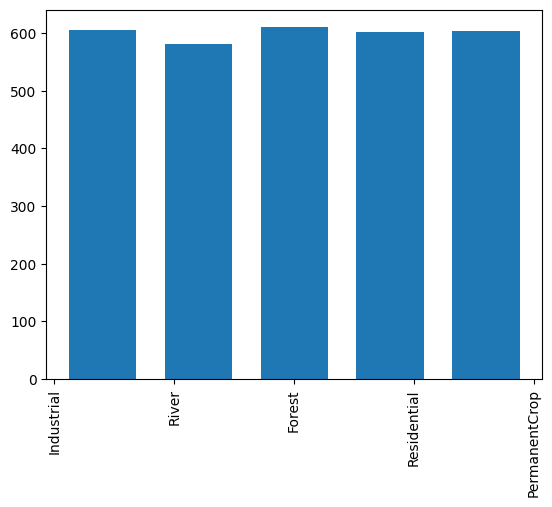

In [9]:
# Observar distribucón de clases en el conjunto de datos de entrenamiento
plt.hist(y_train, bins=5, rwidth=0.7)
plt.xticks(rotation='vertical')
plt.show()

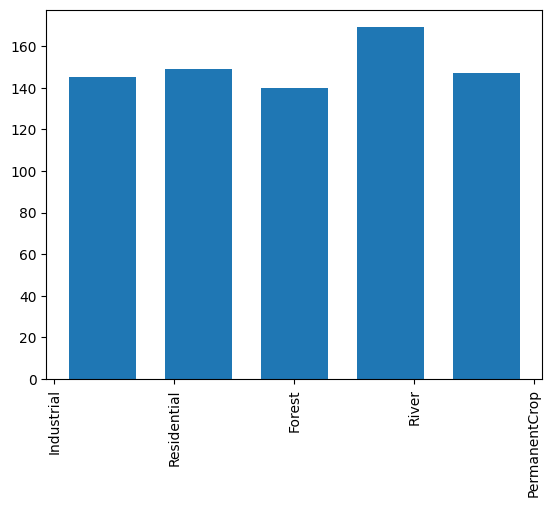

In [10]:
# Observar distribucón de clases en el conjunto de datos de prueba
plt.hist(y_test, bins=5, rwidth=0.7)
plt.xticks(rotation='vertical')
plt.show()

Como podemos observar el conjunto de datos esta bien balanceado, por lo que va a facilitar el desarrollo del modelo pues no se requieren tecnicas adicionales como sobremuestreo, submuestreo o aprendizaje sensitivo al costo.

Ahora procedemos a observar algunas imagenes del dataset aleatoriamente. Escogiendo dos imagenes de cada categoria para hacernos una mejor idea de la clasificacion existente.

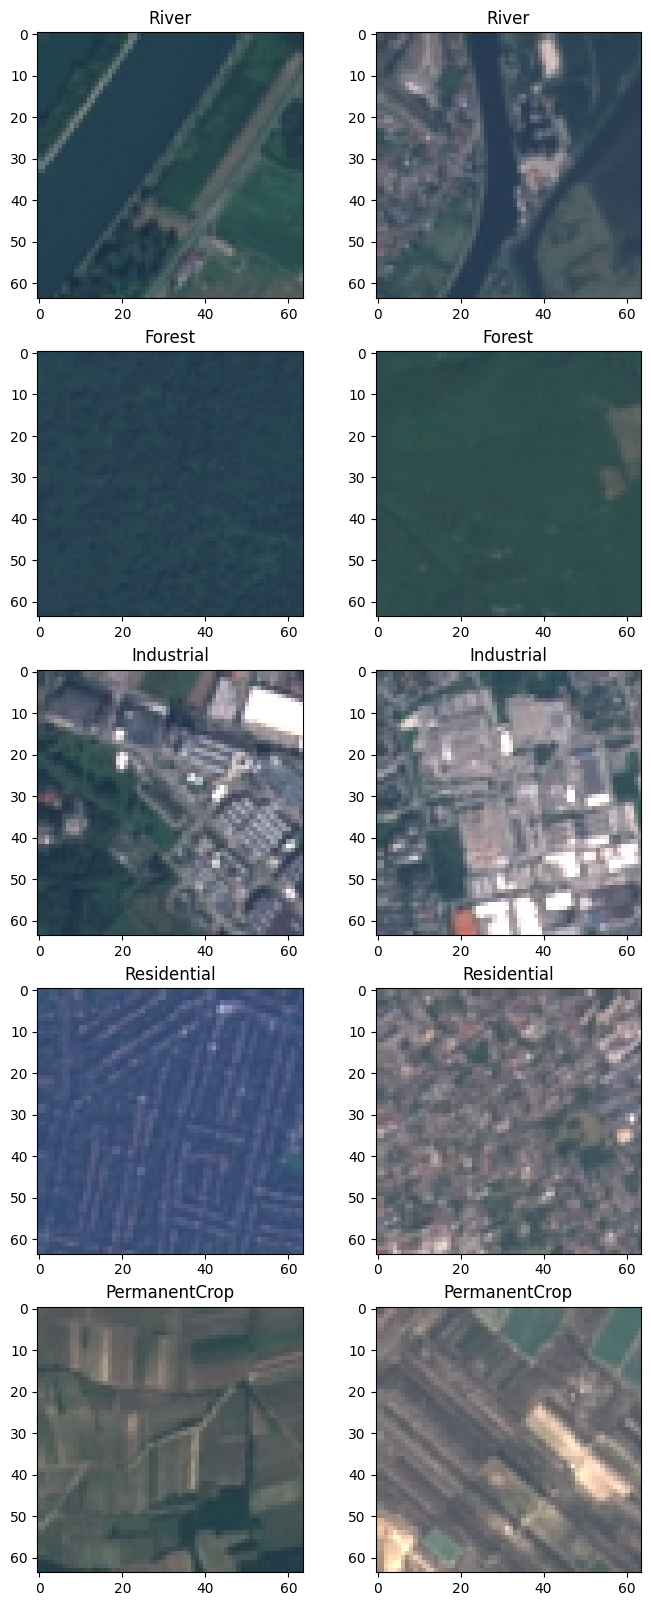

In [12]:
# Observar las imágenes
plt.figure(figsize=(8,20))

classes = list(set(y_train))

for j, cur_class in enumerate(classes):
  # Obtener los indices de las imageness de la clase actual
  indices = [i for i, x in enumerate(y_train) if x == cur_class]

  # Seleccionar dos imagenes aleatorias de esta clase
  random_indices = random.sample(indices, 2)

  for i, index in enumerate(random_indices):
    plt.subplot(len(classes), 2, j*2 + i + 1)
    plt.imshow(x_train[index])
    plt.title(y_train[index])

## 1.2. Preparacion de los datos

##### 1.2.1. Estandarizacion a media 0 y desviación 1

In [13]:
# Aplanamos las imágenes a vectores 1D para facilitar el procesamiento de los datos.
x_train_standard = x_train.reshape(x_train.shape[0], -1)
x_test_standard = x_test.reshape(x_test.shape[0], -1)

x_train_standard = StandardScaler().fit_transform(x_train_standard)
x_test_standard = StandardScaler().fit_transform(x_test_standard) 

x_train_standard[:10, :3]

array([[ 0.39370755,  0.6000537 ,  0.51436838],
       [ 1.80143528,  2.09537131,  1.89328192],
       [-0.74029533, -0.26262953, -0.46096071],
       [-0.23194921, -0.34889786, -0.36006459],
       [-1.01402017, -1.06780055, -1.16723349],
       [ 1.58636576,  1.52024916,  2.19597025],
       [-0.60343292, -0.34889786,  0.91795283],
       [ 0.33505223,  0.77259035,  0.51436838],
       [-0.36881163, -0.06133678, -0.42732867],
       [ 1.05846787,  0.88761478,  1.35516932]])

Antes de aplicar cualquier algoritmo de aprendizaje, vamos a realizar ingeneria de caracteristicas para reducir la dimensionalidad de los datos y mejorar el rendimiento al entrenar el modelo.

Para ello, usaremos una transformacion intermedia para encontrar las caracteristicas que mejor describan la varianza de los datos.


##### 1.2.2. Analisis de componentes principales

In [14]:
x_train_standard[0].shape

(12288,)

In [15]:
# Dimensionalidad de los datos sin PCA
x_train_standard.shape

(3000, 12288)

In [16]:
# Conservar el 95% de la varianza para buscar un buen modelo
pca = PCA(0.90).fit(x_train_standard)

In [17]:
x_train_pca = pca.transform(x_train_standard)
x_test_pca = pca.transform(x_test_standard)

In [18]:
# Numero de componentes principales
print(f"El número de componente principales que conservan el 95% de la varianza es: {pca.n_components_}")

# Dimensionalidad de los datos con PCA
x_train_pca.shape

El número de componente principales que conservan el 95% de la varianza es: 181


(3000, 181)

Con este procedimiento reducimos la dimensionalidad de cada imagen a 181 caracteristicas.

# 2. Gradient Boosting

El algoritmo de *Gradient Boosting* es un metodo de ensemble - un conjunto de modelos cuyas decisiones son combinadas para producir la clasificacion final de un dato.

Hace uso de descenso por el gradiente para ajustar los errores residuales cometidos por los modelos anteriores.

##### 2.1. Crear clasificador

Dado que este algoritmo es resistente a overfitting, incrementamos el numero de estimadores con el fin de obtener idealmente un mejor modelo. Tambien, hacemos una busqueda de hiperparametros de `min_samples_split` y `max_depth`. El primer parametro controla el minimo numero de muestras que se necesitan para dividir un nodo de los arboles de decision que utiliza este clasificador internamente. Y el segundo parametro controla la maxima profundidad de estos arboles.

In [18]:
min_samples_split = [2,3]
max_depth = [3,5]

# Grid search
grid_search = GridSearchCV(GradientBoostingClassifier(n_estimators=110, random_state=0), 
                           param_grid={'min_samples_split': min_samples_split, 'max_depth': max_depth}, 
                           cv=3, n_jobs=-1)

##### 2.2. Entrenar el clasificador con los datos de entrenamiento

**fit**: Este método entrena el clasificador usando el conjunto de datos de entrenamiento proporcionado. x_train_pca contiene las características de los datos de entrenamiento, ya reducidas en dimensiones mediante PCA(Análisis de Componentes Principales).

In [19]:
# Entrenar el clasificador con los datos de entrenamiento
# Entrenamiento y creación del modelo
start = time.time()
grid_search.fit(x_train_pca, y_train)
# Tiempo de entrenamiento
end = time.time()
print(f"Tiempo de entrenamiento: {(end - start)/60} minutos")

# Mejor modelo
best_model = grid_search.best_estimator_

Tiempo de entrenamiento: 2.277980931599935 minutos


In [20]:
# Mejores parámetros
best_params = grid_search.best_params_
print(f"Mejores parámetros: {best_params}")

Mejores parámetros: {'max_depth': 3, 'min_samples_split': 2}


Se obtuvo que los mejores parametros del modelo correspondian a los parametros por defecto.

##### 2.3. Predicciones en datos de entrenamiento

In [21]:
# Realizar predicciones en los datos de entrenamiento
y_train_pred = best_model.predict(x_train_pca)

Precisión de Gradient Boosting: 0.9936666666666667

Informe de clasificación de Gradient Boosting:
               precision    recall  f1-score   support

       Forest       1.00      1.00      1.00       610
   Industrial       1.00      1.00      1.00       605
PermanentCrop       1.00      0.97      0.99       603
  Residential       0.98      1.00      0.99       601
        River       0.99      1.00      0.99       581

     accuracy                           0.99      3000
    macro avg       0.99      0.99      0.99      3000
 weighted avg       0.99      0.99      0.99      3000


Matriz de confusión de Gradient Boosting:


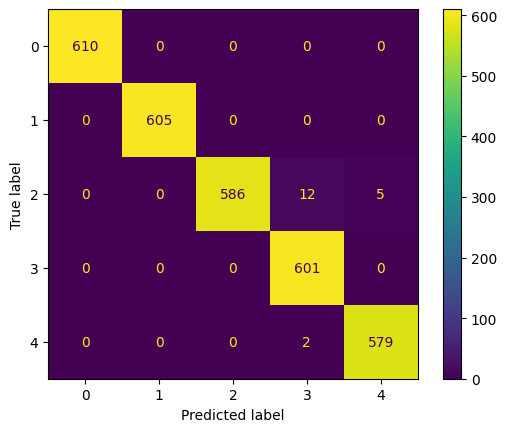

In [22]:
# Precisión
print("Precisión de Gradient Boosting:", accuracy_score(y_train, y_train_pred))

# Informe de clasificación
print("\nInforme de clasificación de Gradient Boosting:")
print(classification_report(y_train, y_train_pred))

# Matriz de confusión
print("\nMatriz de confusión de Gradient Boosting:")
cm_rf = confusion_matrix(y_train, y_train_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.show()

El modelo tiene muy buenos resultados sobre el conjunto de entrenamiento lo que sugiere un bias muy bajo.

##### 3.4. Predicciones en datos de prueba

In [23]:
# Realizar predicciones en los datos de prueba
y_test_pred = best_model.predict(x_test_pca)

Precisión de Gradient Boosting: 0.836

Informe de clasificación de Gradient Boosting:
               precision    recall  f1-score   support

       Forest       0.95      0.99      0.97       140
   Industrial       0.89      0.88      0.89       145
PermanentCrop       0.71      0.73      0.72       147
  Residential       0.75      0.74      0.75       149
        River       0.88      0.85      0.86       169

     accuracy                           0.84       750
    macro avg       0.84      0.84      0.84       750
 weighted avg       0.84      0.84      0.84       750


Matriz de confusión de Gradient Boosting:


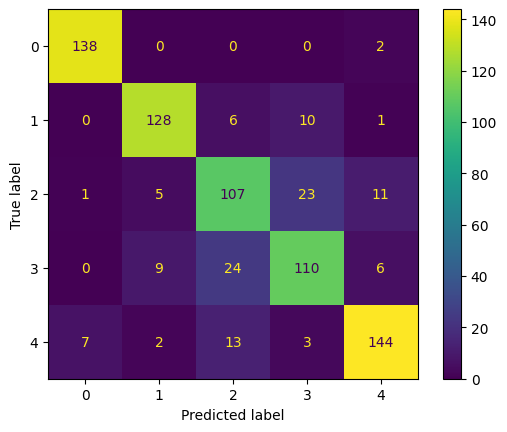

In [24]:
# Precisión
print("Precisión de Gradient Boosting:", accuracy_score(y_test, y_test_pred))

# Informe de clasificación
print("\nInforme de clasificación de Gradient Boosting:")
print(classification_report(y_test, y_test_pred))

# Matriz de confusión
print("\nMatriz de confusión de Gradient Boosting:")
cm_rf = confusion_matrix(y_test, y_test_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.show()

El error en el conjunto de entrenamiento es mas significativo, por lo que podriamos estar frente a una situacion de alta varianza. Aunque predice con mucha precision imagenes de tipo bosque e industrial.

### 2.5. Análisis comparativo respecto al modelo presentado en la práctica (RandomForest)

##### 2.5.1. Crear clasificador

Con fines comparativos, entrenamos ahora un clasificador *Random Forest*. Es un metodo similar que utiliza varios arboles de decision y combina las respuestas de estos modelos en una sola.

Usamos GridSearch para usar una busqueda de los hiperparametros que producen el mejor modelo.

In [18]:
min_samples_split = [5, 7]
max_depth = [10, 15]
n_estimators = [500]


# Grid search
grid_search = GridSearchCV(RandomForestClassifier(criterion='entropy', random_state=0), param_grid={
    'min_samples_split': min_samples_split, 
    'max_depth': max_depth,
    'n_estimators': n_estimators
    }, cv=3, n_jobs=-1)

##### 2.5.2. Entrenar el clasificador con los datos de entrenamiento

In [19]:
# Entrenar el clasificador con los datos de entrenamiento
# Entrenamiento y creación del modelo
start = time.time()
grid_search.fit(x_train_pca, y_train)
# Tiempo de entrenamiento
end = time.time()
print(f"Tiempo de entrenamiento: {(end - start)/60} minutos")

# Mejor modelo
rf_model = grid_search.best_estimator_

Tiempo de entrenamiento: 0.5768119335174561 minutos


In [20]:
# Mejores parámetros
best_params = grid_search.best_params_
print(f"Mejores parámetros: {best_params}")

Mejores parámetros: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 500}


##### 2.5.3. Predicciones en datos de entrenamiento

In [21]:
# Realizar predicciones en los datos de entrenamiento
y_train_pred = rf_model.predict(x_train_pca)

Precisión de Random Forest: 1.0

Informe de clasificación de Random Forest:
               precision    recall  f1-score   support

       Forest       1.00      1.00      1.00       610
   Industrial       1.00      1.00      1.00       605
PermanentCrop       1.00      1.00      1.00       603
  Residential       1.00      1.00      1.00       601
        River       1.00      1.00      1.00       581

     accuracy                           1.00      3000
    macro avg       1.00      1.00      1.00      3000
 weighted avg       1.00      1.00      1.00      3000


Matriz de confusión de Random Forest:


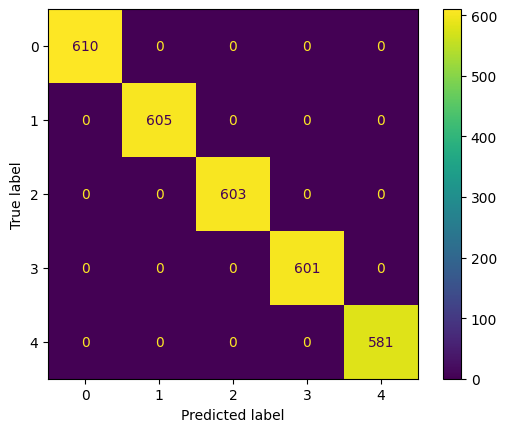

In [22]:
# Precisión
print("Precisión de Random Forest:", accuracy_score(y_train, y_train_pred))

# Informe de clasificación
print("\nInforme de clasificación de Random Forest:")
print(classification_report(y_train, y_train_pred))

# Matriz de confusión
print("\nMatriz de confusión de Random Forest:")
cm_rf = confusion_matrix(y_train, y_train_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.show()

En este caso, el rendimiento con el conjunto de entrenamiento es equivalente al algoritmo de *Gradient Boosting Classifier*.

##### 2.5.4. Predicciones en datos de prueba

In [23]:
# Realizar predicciones en los datos de prueba
y_test_pred = rf_model.predict(x_test_pca)

Precisión de Random Forest: 0.8226666666666667

Informe de clasificación de Random Forest:
               precision    recall  f1-score   support

       Forest       0.98      0.96      0.97       140
   Industrial       0.88      0.90      0.89       145
PermanentCrop       0.71      0.70      0.70       147
  Residential       0.77      0.76      0.76       149
        River       0.79      0.80      0.80       169

     accuracy                           0.82       750
    macro avg       0.83      0.83      0.83       750
 weighted avg       0.82      0.82      0.82       750


Matriz de confusión de Random Forest:


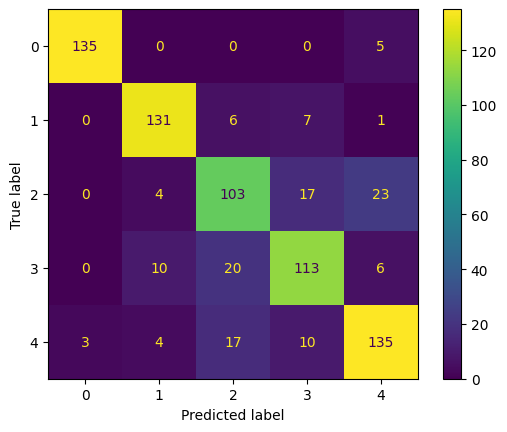

In [24]:
# Precisión
print("Precisión de Random Forest:", accuracy_score(y_test, y_test_pred))

# Informe de clasificación
print("\nInforme de clasificación de Random Forest:")
print(classification_report(y_test, y_test_pred))

# Matriz de confusión
print("\nMatriz de confusión de Random Forest:")
cm_rf = confusion_matrix(y_test, y_test_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.show()

*Gradient Boosting Classifier* muestra un desempeño global ligeramente superior al de *Random Forest*. Sin embargo, su entrenamiento es considerablemente más lento.

La implementación mostrada en el laboratorio de *Random Forest*, el desempeño es apenas inferior a la mostrada aquí. La optimización de los hiperparámetros nos ayudólograr un desempeño casi igual al *Gradient Boosting Classifier*, pero invirtiendo mucho menos tiempo en el entrenamiento.

# 3. Otro modelo de ensamble (Histogram-based Gradient Boosting Classification Tree)

Es una implementación más eficiente de Gradient Boosting que utiliza histogramas para optimizar los cálculos, lo que lo hace más rápido y adecuado para conjuntos de datos grandes.

##### 3.1. Crear clasificador

In [76]:
max_iter = [100, 300, 500]
max_depth = [15, 30]

# Grid search
grid_search = GridSearchCV(HistGradientBoostingClassifier(random_state=0, min_samples_leaf=50), 
                           param_grid={'max_iter': max_iter, 'max_depth': max_depth,
                                       }, 
                           cv=3, n_jobs=-1)

##### 3.2. Entrenar el clasificador con los datos de entrenamiento

In [77]:
# Entrenar el clasificador con los datos de entrenamiento
# Entrenamiento y creación del modelo
start = time.time()
grid_search.fit(x_train_pca, y_train)
# Tiempo de entrenamiento
end = time.time()
print(f"Tiempo de entrenamiento: {(end - start)/60} minutos")

# Mejor modelo
hgbc_model = grid_search.best_estimator_

Tiempo de entrenamiento: 0.19975556135177613 minutos


In [78]:
# Mejores parámetros
best_params = grid_search.best_params_
print(f"Mejores parámetros: {best_params}")

Mejores parámetros: {'max_depth': 15, 'max_iter': 500, 'min_samples_leaf': 50}


##### 3.3. Predicciones en datos de entrenamiento

In [79]:
# Realizar predicciones en los datos de entrenamiento
y_train_pred = hgbc_model.predict(x_train_pca)

Histogram-based Gradient Boosting Classification Tree: 1.0

Informe de clasificación de Histogram-based Gradient Boosting Classification Tree::
               precision    recall  f1-score   support

       Forest       1.00      1.00      1.00       610
   Industrial       1.00      1.00      1.00       605
PermanentCrop       1.00      1.00      1.00       603
  Residential       1.00      1.00      1.00       601
        River       1.00      1.00      1.00       581

     accuracy                           1.00      3000
    macro avg       1.00      1.00      1.00      3000
 weighted avg       1.00      1.00      1.00      3000


Matriz de confusión de Histogram-based Gradient Boosting Classification Tree:


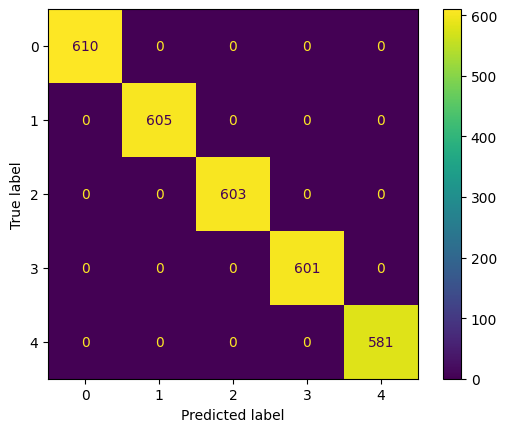

In [80]:
# Precisión
print("Histogram-based Gradient Boosting Classification Tree:", accuracy_score(y_train, y_train_pred))

# Informe de clasificación
print("\nInforme de clasificación de Histogram-based Gradient Boosting Classification Tree::")
print(classification_report(y_train, y_train_pred))

# Matriz de confusión
print("\nMatriz de confusión de Histogram-based Gradient Boosting Classification Tree:")
cm_rf = confusion_matrix(y_train, y_train_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.show()

El rendimiento sobre el conjunto de prueba es equivalente a las dos propuestas anteriores

##### 3.4. Predicciones en datos de prueba

In [81]:
# Realizar predicciones en los datos de prueba
y_test_pred = hgbc_model.predict(x_test_pca)

Histogram-based Gradient Boosting Classification Tree: 0.8533333333333334

Informe de clasificación de Histogram-based Gradient Boosting Classification Tree:
               precision    recall  f1-score   support

       Forest       0.96      0.98      0.97       140
   Industrial       0.90      0.88      0.89       145
PermanentCrop       0.76      0.76      0.76       147
  Residential       0.78      0.77      0.77       149
        River       0.87      0.88      0.87       169

     accuracy                           0.85       750
    macro avg       0.85      0.85      0.85       750
 weighted avg       0.85      0.85      0.85       750


Matriz de confusión de Histogram-based Gradient Boosting Classification Tree:


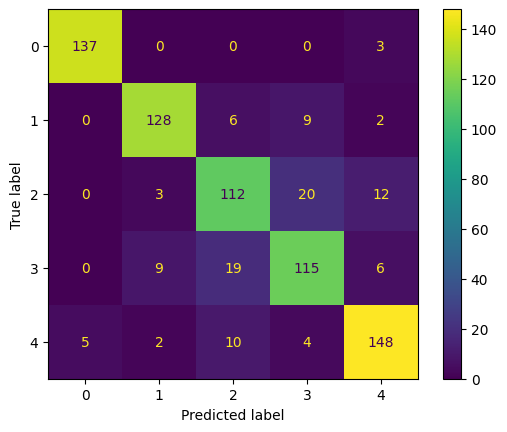

In [82]:
# Precisión
print("Histogram-based Gradient Boosting Classification Tree:", accuracy_score(y_test, y_test_pred))

# Informe de clasificación
print("\nInforme de clasificación de Histogram-based Gradient Boosting Classification Tree:")
print(classification_report(y_test, y_test_pred))

# Matriz de confusión
print("\nMatriz de confusión de Histogram-based Gradient Boosting Classification Tree:")
cm_rf = confusion_matrix(y_test, y_test_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.show()


Histogram-based Gradient Boosting Classification Tree alcanzó el mayor rendimiento entre los tres modelos y tomando menos tiempo en su entrenamiento

## 3.5 Conclusiones: comparación entre modelos 

Los tres modelos alcanzaron rendimientos similares en los datos de prueba, una vez optimizados los hiperparámetros. Random Forest registró el desempeño más bajo con una precisión global del 0.82, mientras que el Histogram-based Gradient Boosting Classification Tree logró la precisión más alta con un 0.85.

Aunque Gradient Boosting alcanzó una precisión global de aproximadamente el 0.84, su tiempo de entrenamiento es considerablemente mayor comparado con los otros dos modelos. Este es un factor relevante a considerar, ya que el tiempo de inversión no parece justificar el rendimiento en comparación con las otras dos alternativas. Adicionalmente, es importante destacar que el Histogram-based Gradient Boosting Classification Tree no solo logró el mejor desempeño, sino que también fue el más rápido en completar su entrenamiento. Esto lo convierte en una excelente opción para la implementación del algoritmo Gradient Boosting en conjuntos de datos de gran tamaño, como es el caso de las imágenes satelitales.